This notebook produces photo-z predictions for a set of 119,899 objects.  The objective is to compare regressions trained on photometric colors alone, colors and dcr offset, colors and proper motions, and colors + dcr offset + GAIA proper motions.  We also want to attempt to use the regression to do object classification as well.  

Matching summary for data table used: <br>
gtr match to spAll-dr12 table from SDSS dr12 <br>
match resulting table to gaia with query: <br>
SELECT gaia.ra, gaia.dec, gaia.pmra, gaia.pmdec <br>
FROM gaiadr2.gaia_source as gaia <br>
INNER JOIN user_[USERNAME].xmatch_gaia_source_[TABLENAME] ON user_[USERNAME].xmatch_gaia_source_[TABLENAME].gaia_source_source_id = gaia.source_id <br>

Produces file gtr_all+dr12offset+gaia.fits

In [1]:
import numpy as np
from astropy.table import Table
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import classification_report
from astroML.linear_model import NadarayaWatson
from dask import compute, delayed
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import palettable
import richardsplot as rplot
%matplotlib inline

In [2]:
def absoluteMagnitude(xarray, yarray):
    if len(xarray) != len(yarray):
        print("The two arrays must be the same length")
        return
    else:
        absMag = []
        for i in range(len(xarray)):
            if (not np.isnan(xarray[i])) and (not np.isnan(yarray[i])):
                absMag = np.append(absMag, np.sqrt((xarray[i]*xarray[i])+(yarray[i]*yarray[i])))
            else:
                absMag = np.append(absMag, -1000000)
        return absMag

In [3]:
data = Table.read('gtr_all+dr12offset+gaia.fits')
data=data.filled()

In [4]:
print data.keys()

['ug', 'gr', 'ri', 'iz', 'zs1', 's1s2', 'ra_1', 'dec_1', 'iflux', 'zspec', 'extinctu', 'imag', 'morph', 'labels', 'OFFSETRA', 'OFFSETDEC', 'pmra', 'pmdec']


In [5]:
def process(Xin):
    return model.predict(Xin)



In [6]:
OFFSETABS_u = absoluteMagnitude(data['OFFSETRA'].T[0], data['OFFSETDEC'].T[0])
OFFSETABS_g = absoluteMagnitude(data['OFFSETRA'].T[1], data['OFFSETDEC'].T[1])
pmabs = absoluteMagnitude(data['pmra'], data['pmdec'])
print data['OFFSETRA'].T[0]
print data['OFFSETRA'].T[1]

[-0.01096182  0.12641716 -0.03178377 ... -0.02113518  0.0083106
  0.05506986]
[ 0.01051129 -0.06123416 -0.09891617 ...  0.02388048  0.04641511
  0.08676223]


In [7]:
#1 is colors, 2 is colors+offset, 3 is colors+proper motion, 4 is colors+offset+proper motion
X1 = np.vstack([ data['ug'], data['gr'], data['ri'], data['iz'] ]).T
X2 = np.vstack([ data['ug'], data['gr'], data['ri'], data['iz'], OFFSETABS_u, OFFSETABS_g ]).T
X3 = np.vstack([ data['ug'], data['gr'], data['ri'], data['iz'], pmabs ]).T
X4 = np.vstack([ data['ug'], data['gr'], data['ri'], data['iz'], OFFSETABS_u, OFFSETABS_g, pmabs ]).T
y = np.array(data['zspec'])
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y, test_size = 0.2, random_state=57)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size = 0.2, random_state=57)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y, test_size = 0.2, random_state=57)
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y, test_size = 0.2, random_state=57)
import dask.threaded
model = NadarayaWatson('gaussian', 0.05)
model.fit(X1_train, y1_train)
dobjs = [delayed(process)(x.reshape(1,-1)) for x in X1_test]
ypredselfNW1 = compute(*dobjs, get=dask.threaded.get)
ypredselfNW1 = np.array(ypredselfNW1).reshape(1,-1)[0]
del model
del dobjs
model = NadarayaWatson('gaussian', 0.05)
model.fit(X2_train, y2_train)
dobjs = [delayed(process)(x.reshape(1,-1)) for x in X2_test]
ypredselfNW2 = compute(*dobjs, get=dask.threaded.get)
ypredselfNW2 = np.array(ypredselfNW2).reshape(1,-1)[0]
del model
del dobjs
model = NadarayaWatson('gaussian', 0.05)
model.fit(X3_train, y3_train)
dobjs = [delayed(process)(x.reshape(1,-1)) for x in X3_test]
ypredselfNW3 = compute(*dobjs, get=dask.threaded.get)
ypredselfNW3 = np.array(ypredselfNW3).reshape(1,-1)[0]
del model
del dobjs
model = NadarayaWatson('gaussian', 0.05)
model.fit(X4_train, y4_train)
dobjs = [delayed(process)(x.reshape(1,-1)) for x in X4_test]
ypredselfNW4 = compute(*dobjs, get=dask.threaded.get)
ypredselfNW4 = np.array(ypredselfNW4).reshape(1,-1)[0]


c:\python27\lib\site-packages\dask\base.py:835: UserWarning: The get= keyword has been deprecated. Please use the scheduler= keyword instead with the name of the desired scheduler like 'threads' or 'processes'
  warnings.warn("The get= keyword has been deprecated. "
c:\python27\lib\site-packages\astroML\linear_model\kernel_regression.py:52: RuntimeWarning: invalid value encountered in divide
  return (K * self.y).sum(1) / K.sum(1)


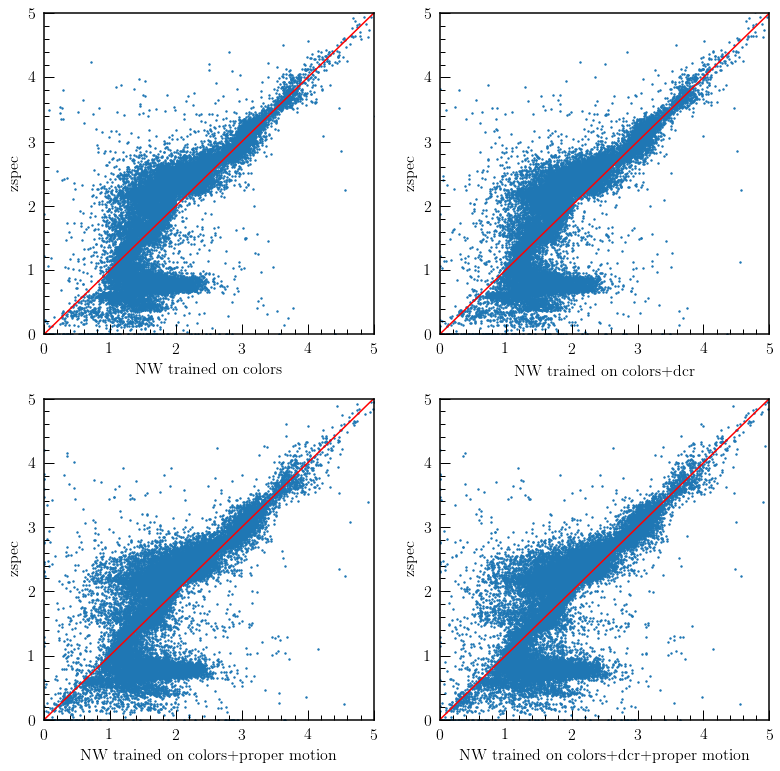

In [10]:
plt.figure(figsize=(13,13))
plt.subplot(221)
plt.scatter(ypredselfNW1, y1_test, s=2)
plt.plot([0,1,2,3,4,5], color='red')
plt.xlabel('NW trained on colors')
plt.ylabel('zspec')
plt.xlim(0,5)
plt.ylim(0,5)
plt.subplot(222)
plt.scatter(ypredselfNW2, y2_test, s=2)
plt.plot([0,1,2,3,4,5], color='red')
plt.xlabel('NW trained on colors+dcr')
plt.ylabel('zspec')
plt.xlim(0,5)
plt.ylim(0,5)
plt.subplot(223)
plt.scatter(ypredselfNW3, y3_test, s=2)
plt.plot([0,1,2,3,4,5], color='red')
plt.xlabel('NW trained on colors+proper motion')
plt.ylabel('zspec')
plt.xlim(0,5)
plt.ylim(0,5)
plt.subplot(224)
plt.scatter(ypredselfNW4, y4_test, s=2)
plt.plot([0,1,2,3,4,5], color='red')
plt.xlabel('NW trained on colors+dcr+proper motion')
plt.ylabel('zspec')
plt.xlim(0,5)
plt.ylim(0,5)

plt.savefig("gtr_all_NWout.png", dpi = 400)

Above scatter plots show the photometric redshift predictions made by a Nadaraya-Watson regression trained on ug, gr, ri, and iz colors, angular offsets in the u and g bands, and proper motion as measured by the GAIA DR2 survey.  The x-axis coordinates show the distribution of our prediction and the y-axis coordinates show the distribution of the spectroscopic redshift.  The red lines show the lines along which the two are equal, corresponding to a "correct" prediction.  The top left panel shows a prediction trained on colors alone, the top right shows a prediction trained on colors and angular offset, the bottom left shows a prediction trained on colors and proper motion, and the bottom right shows a prediction trained on colors, angular offset, and proper motion.  The angular offsets are in the u and g bands as reported in SDSS DR12 and the proper motions are as reported by GAIA DR2.  